In [14]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
DATASET_PATH = '/content/drive/MyDrive/bilane/images'
MODEL_PATH = '/content/drive/MyDrive/bilane/resnet18_letters.pth'

Вам предстоит создать алгоритм по деформации (выравниваню) автомобильных номеров и поместить его в функцию img_deformation.


! Вы не можете менять заданную OCR модель (дообучать тоже нельзя) и заданные шаблоны по разбиению изображения.

! Допустимы небольшие измениния трех основных .py файлов, если в этом есть необходимость для встраивания в ваши решения. Но их функционал должен быть сохранен.

# Файлы для работы с шаблонами

В разделе "Алогритм" показано что для чего нужно, так что имеет смысл сначала посетить его

## model.py

In [16]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18

label2letter = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9",
    10: "A", 11: "B", 12: "C", 13: "E", 14: "H", 15: "K", 16: "M", 17: "O", 18: "P", 19: "T", 20: "X", 21: "Y"
}

class LettersPrediction(object):
    def __init__(self):
        self.model = resnet18()
        self.model.fc = nn.Linear(self.model.fc.in_features, out_features=22)
        self.model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))
        self.model.eval()

        self.imgsz = 64

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((self.imgsz, self.imgsz)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def predict(self, img):
        input_tensor = self.transform(img)
        output_tensor = self.model(input_tensor.unsqueeze(0))
        predicted = torch.argmax(output_tensor)
        return label2letter[predicted.item()]

    def predict_series(self, imgs):
        s = ""
        for img in imgs:
            s += self.predict(img)
        return s

## template.py

Разбивает изображение на части по шаблонам

In [30]:
from pathlib import Path
import numpy as np

two_digit_region_template = [
    {'pos': 1, 'p1': (0.067, 0.250), 'p2': (0.177, 0.92)},
    {'pos': 2, 'p1': (0.19, 0.100), 'p2': (0.3, 0.92)},
    {'pos': 3, 'p1': (0.3, 0.100), 'p2': (0.41, 0.92)},
    {'pos': 4, 'p1': (0.41, 0.100), 'p2': (0.52, 0.92)},
    {'pos': 5, 'p1': (0.53, 0.250), 'p2': (0.64, 0.92)},
    {'pos': 6, 'p1': (0.64, 0.250), 'p2': (0.75, 0.92)},
    {'pos': 7, 'p1': (0.77, 0.05), 'p2': (0.86, 0.7)},
    {'pos': 8, 'p1': (0.86, 0.05), 'p2': (0.95, 0.7)}
]

three_digit_region_template = [
    {'pos': 1, 'p1': (0.05, 0.250), 'p2': (0.16, 0.92)},
    {'pos': 2, 'p1': (0.16, 0.100), 'p2': (0.27, 0.92)},
    {'pos': 3, 'p1': (0.265, 0.100), 'p2': (0.375, 0.92)},
    {'pos': 4, 'p1': (0.37, 0.100), 'p2': (0.48, 0.92)},
    {'pos': 5, 'p1': (0.475, 0.250), 'p2': (0.585, 0.92)},
    {'pos': 6, 'p1': (0.58, 0.250), 'p2': (0.69, 0.92)},
    {'pos': 7, 'p1': (0.71, 0.05), 'p2': (0.795, 0.7)},
    {'pos': 8, 'p1': (0.79, 0.05), 'p2': (0.875, 0.7)},
    {'pos': 9, 'p1': (0.87, 0.05), 'p2': (0.96, 0.7)}
]

def apply_template(img, region_length):
    if region_length == 2:
        pattern = two_digit_region_template
    elif region_length == 3:
        pattern = three_digit_region_template
    else:
       raise ValueError("Неподдерживаемое разбиение на регионы. Поддерживаются только 2 и 3.")

    H, W, _ = img.shape

    if H != 112 or W != 512:
        raise ValueError("Форма изображения должна быть 512x112")

    crops = []
    for pos in pattern:
        sx, sy, ex, ey = *pos["p1"], *pos["p2"]
        sx, sy, ex, ey = sx * W, sy * H, ex * W, ey * H
        sx, sy, ex, ey = map(int, [sx, sy, ex, ey])
        crops.append(img[sy : ey, sx : ex])

    return crops


## Функция для деформации

Пропишите логику алгоритма по деформации внутри фунции img_deformation

In [44]:
import cv2
import numpy as np


def resizeImg(image, height=100):
    '''
    функция для ресайза изображений с сохранением пропорций их сторон
    '''
    h, w = image.shape[:2]
    pro = height / h
    size = (int(w * pro), int(height))
    img = cv2.resize(image, size)
    return img


def getCanny(image):
    '''
    функция для выделения всех контуров на изображении
    '''

    # переводим изображение в ЧБ формат и немного зашумляем для размытия нечетких контуров
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary = cv2.GaussianBlur(gray, (3, 3), 2, 2)

    top_border_canny = 800 # верхняя граница выделения контуров
    bot_border_canny = 200 # нижняя граница выделения контуров
    bot_border = 10 # нижняя граница количества контуров
    top_border = 30 # верхняя граница количества контуров
    step = 10 # шаг изменения border_canny
    i = 0 # счетчик шагов
    # подбираем границы выделения контуров для функции Canny таким образом, чтобы количество
    # контуров попало в диапазон [bot_border, top_border]. Если выделилось слишком много
    # контуров, сужаем диапазон. Так же наоборот
    while i < 10:
        # выделяем контуры
        canny = cv2.Canny(binary, bot_border_canny, top_border_canny)
        kernel = np.ones((3, 3), np.uint8)
        contours, _ = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        print(top_border_canny, len(contours))

        # меняем границу выделения контуров в зависимости от количества выделенных контуров
        if len(contours) >= bot_border and len(contours) <= top_border:
            break
        elif len(contours) > top_border:
            top_border_canny += step
        else:
            top_border_canny -= step
        i += 1

    return canny


def findTotalContour(img):
    '''
    функция для объединения всех контуров в один, соответствующий рамке номера
    '''
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    total_contour = contours[0]
    # конкатенация контуров
    for i in range(1, len(contours)):
        total_contour = np.concatenate((total_contour, contours[i]), axis=0)
    # обобщение контуров в один
    hull = cv2.convexHull(total_contour)
    return hull


def normalize_img(img):
    # нормализация изображений
    img = cv2.normalize(
        img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return img


def sharpened_img(img):
    # повышение резкости изображений
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]) # Sharpen the image
    img = cv2.filter2D(img, -1, kernel)
    return img


def lab_img(img):
    # повышение контрастности изображений методом LAB
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)
    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)
    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))
    # Converting image from LAB Color model to BGR color spcae
    img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    #plt.imshow(img)
    #plt.title('lab-method')
    #plt.show()
    return img


def img_deformation(img):
    '''
    основная функция для выравнивания изображений
    '''

    # применение преобразований
    img = normalize_img(img)
    img = sharpened_img(img)
    img = lab_img(img)

    # конструкция try-except для выхода в случае необнаружения контуров на картинке
    try:
        binary_img = getCanny(img)

        max_contour = findTotalContour(binary_img)
        #contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        # используя формулу евклидова расстояния, расчитываем ближайшие точки к каждому из углов изображения
        # они и будут использоваться для выравнивания изображений
        lb_min_d, lt_min_d, rb_min_d, rt_min_d = [img.shape[0] * img.shape[1]]*4
        for point in max_contour:
            x, y = point[0][0], point[0][1]
            lt_d = (x**2 + y**2) ** 0.5
            if lt_d < lt_min_d:
                lt_min_d = lt_d
                lt_point = [x, y]

            lb_d = (x**2 + (y - img.shape[0])**2) ** 0.5
            if lb_d < lb_min_d:
                lb_min_d = lb_d
                lb_point = [x, y]

            rt_d = ((x - img.shape[1])**2 + y**2) ** 0.5
            if rt_d < rt_min_d:
                rt_min_d = rt_d
                rt_point = [x, y]

            rb_d = ((x - img.shape[1])**2 + (y - img.shape[0])**2) ** 0.5
            if rb_d < rb_min_d:
                rb_min_d = rb_d
                rb_point = [x, y]

        # отмечаем угловые точки на изображении
        points = [lt_point, lb_point, rb_point, rt_point]
        copy_img = img.copy()
        for point in points:
            cv2.circle(copy_img, tuple(point), 5, (0, 0, 255), 2)

        cv2.drawContours(img, [max_contour], -1, (0, 0, 255), 2)

        # сопоставляем новые и старые угловые точки
        pts1 = np.float32(points)
        pts2 = np.float32([[0,0], [0,img.shape[0]], [img.shape[1],img.shape[0]], [img.shape[1],0]])

        # используем трансформацию перспективы для конечного выравнивания
        M = cv2.getPerspectiveTransform(pts1, pts2)
        dst = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
        return dst

    except IndexError:
        return img

## predict.py

Выполняет предсказание для изображений разбитых по 2 и 3 шаблону

In [45]:
import argparse
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import pandas as pd

#from template import apply_template
#from model import LettersPrediction

data_path = Path(DATASET_PATH)

def visualize_image(img, title="Image"):
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()


def calculate_accuracy(pred):
    '''
    функция подсчитывает и выводит, какая доля знаков была распознана полностью верно
    '''
    preds = []
    for i in range(pred.shape[0]):
        im_name = pred['image_name'][i]
        targ = data[data['image_name'] == im_name].number.values[0]
        # если один из двух предиктов (для регионов с кодом длины 2 и 3) соответствует правильному ответу, засчитываем как правильный
        if pred['prediction_region_length_2'][i] == targ or pred['prediction_region_length_3'][i] == targ:
            preds.append(1)
        else:
            preds.append(0)
    return sum(preds) / len(preds), sum(preds)


regions_type = [2, 3]
model = LettersPrediction()

cout = 0
result = []
for p in tqdm(data_path.iterdir()):

    if not p.suffix in [".png", ".jpg", ".jpeg"]:
        continue
    result.append(
        {
            "image_name": p.stem,
            "prediction_region_length_2": "",
            "prediction_region_length_3": ""
        }
    )

    img = cv2.imread(str(p))

    #вызов фунции деформации
    #проверяем, были ли найдены контуры
    #в противном случае оставляем картинку без изменений
    try:
        img = img_deformation(img,800, 200)
    except:
        pass

    img = cv2.resize(img, (512,112))
    cout+=1
    for region_type in regions_type:

        crops = apply_template(img, region_type)

        lp_number = model.predict_series(crops)
        result[-1][f"prediction_region_length_{region_type}"] = lp_number

    # if cout == 100:
    #   break
pd.DataFrame(result).to_csv('modelPredict.csv', index=False)
df = pd.read_csv('/content/modelPredict.csv')
print(calculate_accuracy(df))

1029it [07:05,  2.42it/s]


(0.014577259475218658, 15) 800 200


# Алгоритм

![](https://sun9-2.userapi.com/impg/SfgCnkIYJeC_4clAh69dvC6ZwmBT9dLmMkh25A/DvScgey4ZCg.jpg?size=1916x1079&quality=96&sign=2ef5e9fadc1d8635c4963fb99affd07d&type=album)

In [46]:
import matplotlib.pyplot as plt
import os

#Рисует на изображение template
def draw_regions(img, region_length):
    if region_length == 2:
        pattern = two_digit_region_template
    elif region_length == 3:
        pattern = three_digit_region_template
    else:
        raise ValueError("Неподдерживаемое разбиение на регионы. Поддерживаются только 2 и 3.")

    H, W, _ = img.shape

    if H != 112 or W != 512:
        raise ValueError("Форма изображения должна быть 512x112")

    for pos in pattern:
        sx, sy, ex, ey = *pos["p1"], *pos["p2"]
        sx, sy, ex, ey = int(sx * W), int(sy * H), int(ex * W), int(ey * H)
        cv2.rectangle(img, (sx, sy), (ex, ey), (0, 255, 0), 2)

    return img

#Визуализирует изображения из датасета
def draw(folder_path, show_template=False, template=2):

    file_list = os.listdir(folder_path)[:10]
    image_files = [f for f in file_list if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Устанавливаем количество изображений на строку
    images_per_row = 5

    num_rows = len(image_files) // images_per_row + int(len(image_files) % images_per_row != 0)
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))

    for j in range(num_rows * images_per_row):
        if j < len(image_files):
            ax = axes.flat[j]
            img_path = os.path.join(folder_path, image_files[j])
            print(j, image_files[j])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if show_template:
              img = img_deformation(img)
              img = cv2.resize(img, (512,112))
              img_with_rectangles = draw_regions(img, template)

            ax.imshow(img)
            ax.axis('off')
            ax.set_title(os.path.basename(img_path))
        else:
            axes.flat[j].axis('off')

    plt.tight_layout()
    plt.show()

Визуализируем изображения из датасета

0 ca56a60374430162.jpg
1 21a798c4825e5217.jpg
2 58b2228cb7e66614.jpg
3 d5faf04f732bce02.jpg
4 7016b2ac9ce3c278.jpg
5 a97d7bf698aad89d.jpg
6 317bbcb74c01bd33.jpg
7 8fc75e36ebf7f6d8.jpg
8 0d915cba254e1565.jpg
9 81e21f3483fe2d36.jpg


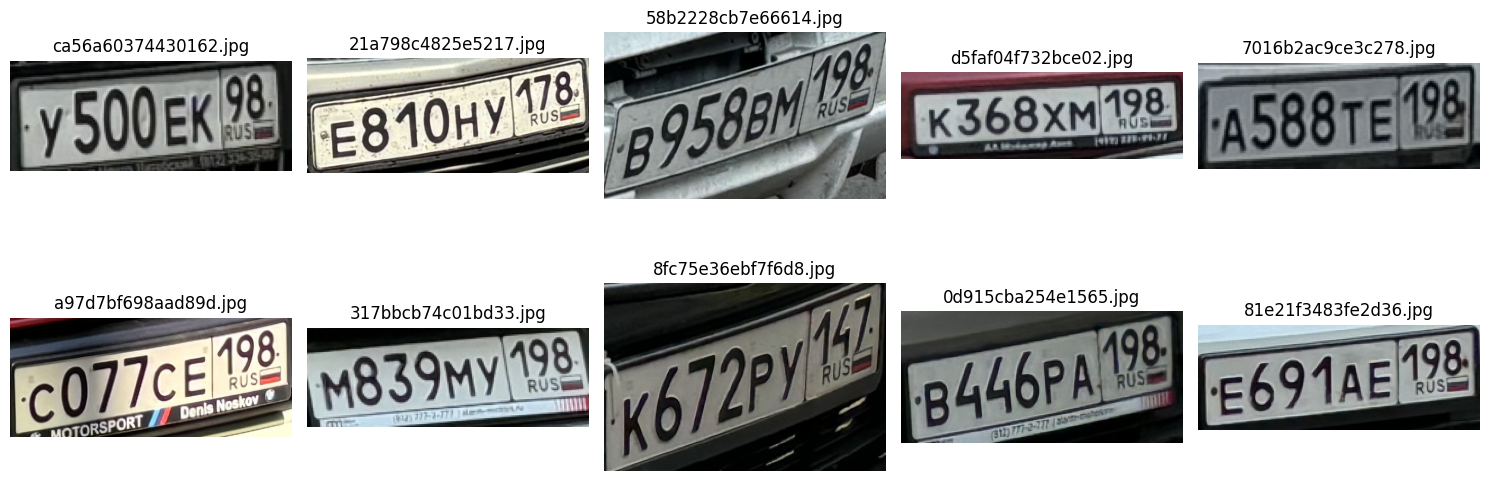

In [36]:
draw(DATASET_PATH, show_template=False)

Теперь визуализируем шаблон 2 для каждого изображения

0 ca56a60374430162.jpg
800 10
1 21a798c4825e5217.jpg
800 14
2 58b2228cb7e66614.jpg
800 19
3 d5faf04f732bce02.jpg
800 5
790 5
780 6
770 6
760 7
750 7
740 7
730 9
720 10
4 7016b2ac9ce3c278.jpg
800 6
790 7
780 7
770 9
760 9
750 9
740 10
5 a97d7bf698aad89d.jpg
800 24
6 317bbcb74c01bd33.jpg
800 13
7 8fc75e36ebf7f6d8.jpg
800 12
8 0d915cba254e1565.jpg
800 15
9 81e21f3483fe2d36.jpg
800 7
790 7
780 7
770 7
760 3
750 3
740 3
730 3
720 3
710 3


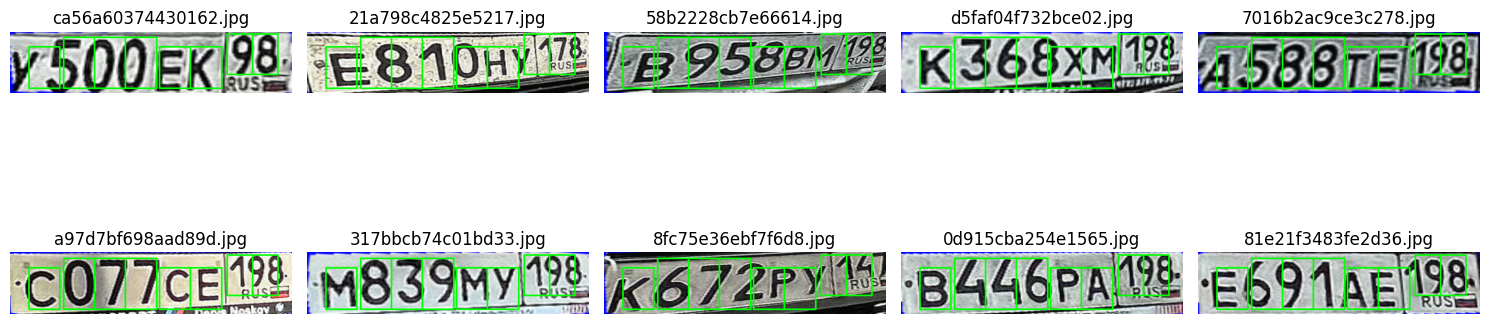

In [37]:
draw(DATASET_PATH, show_template=True)

Теперь визуализируем шаблон 3 для каждого изображения

0 ca56a60374430162.jpg
800 10
1 21a798c4825e5217.jpg
800 14
2 58b2228cb7e66614.jpg
800 19
3 d5faf04f732bce02.jpg
800 5
790 5
780 6
770 6
760 7
750 7
740 7
730 9
720 10
4 7016b2ac9ce3c278.jpg
800 6
790 7
780 7
770 9
760 9
750 9
740 10
5 a97d7bf698aad89d.jpg
800 24
6 317bbcb74c01bd33.jpg
800 13
7 8fc75e36ebf7f6d8.jpg
800 12
8 0d915cba254e1565.jpg
800 15
9 81e21f3483fe2d36.jpg
800 7
790 7
780 7
770 7
760 3
750 3
740 3
730 3
720 3
710 3


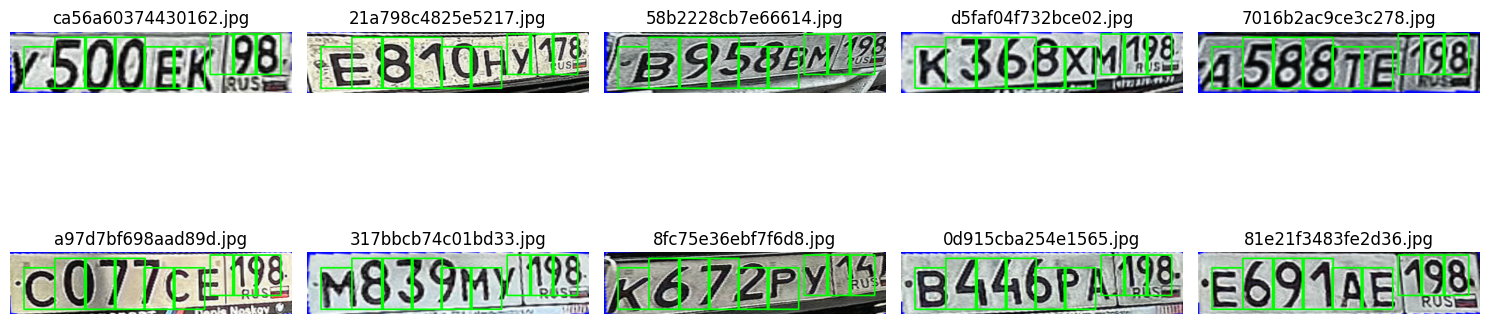

In [38]:
draw(DATASET_PATH, show_template=True, template = 3)

# Подсчёт метрики

In [39]:
preds = pd.read_csv('/content/modelPredict.csv')
data = pd.read_csv('/content/drive/MyDrive/bilane/correspondance.csv')

In [43]:
calculate_accuracy(preds)

(0.07094266277939747, 73)